# Import

In [1]:
from PIL import Image

import gymnasium as gym
from gymnasium.wrappers import TimeLimit
import panda_gym

from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack, VecTransposeImage

from hcr5_reach_with_gripper_env import HCR5ReachWithGripperEnv

pybullet build time: Sep  3 2024 12:59:12


# Constants

In [2]:
env_render_options = {
    "render_width": 480,
    "render_height": 480,
    "render_target_position": [-0.2, 0, 0],
    "render_distance": 1.2,
    "render_yaw": 90,
    "render_pitch": -30,
    "render_roll": 0,
}

# Envorinment setup

In [3]:
class ObsDictToArray(gym.ObservationWrapper):
    """Convert a dict obs {'observation': array, ...} into just the array."""
    def __init__(self, env):
        super().__init__(env)
        # Replace the observation_space with the sub-space you want:
        self.observation_space = self.env.observation_space.spaces["observation"]

    def observation(self, obs_dict):
        # obs_dict is {'observation': ..., 'achieved_goal': ..., ...}
        return obs_dict["observation"]

In [4]:
def make_env():
    # 1) Base goal-based env, which uses the full dict for reward internally
    raw = TimeLimit(HCR5ReachWithGripperEnv(
        render_mode="rgb_array",
        **env_render_options,
        control_type='joints',
        reward_type="combined",
    ),
    max_episode_steps=100)
    wrapped = ObsDictToArray(raw)
    # 2) Wrap it in a Monitor so info["episode"] = {"r": total_reward, "l": length}
    return Monitor(wrapped)


In [ ]:
def make_vec_env(n_envs=1):
    vec_env = DummyVecEnv([make_env for i in range(n_envs)])
    vec_env = VecFrameStack(vec_env, n_stack=4)
    vec_env = VecTransposeImage(vec_env)
    return vec_env

vec_env = make_vec_env(8)
vec_env.observation_space

In [6]:
vec_env.render().shape, vec_env.envs[0].render().shape

((1440, 1440, 3), (480, 480, 3))

In [7]:
observation, info = vec_env.envs[0].reset()
observation, info = vec_env.envs[0].reset()
observation, info = vec_env.envs[0].reset()
observation, info = vec_env.envs[0].reset()
observation, info = vec_env.envs[0].reset()
observation.shape

(96, 96, 3)

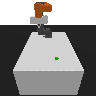

In [8]:
Image.fromarray(observation)

In [9]:
observation = vec_env.reset()
observation.shape

(8, 12, 96, 96)

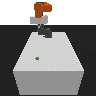

In [10]:
Image.fromarray(observation[0][9:].transpose(1, 2, 0))

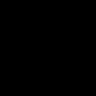

In [11]:
Image.fromarray(observation[0][:3].transpose(1, 2, 0))

# Old Agent

In [ ]:
vec_env = make_vec_env(32)
vec_env

In [13]:
model = PPO(
    "CnnPolicy",
    vec_env,
    verbose=1,
    device="mps",
    learning_rate=5e-5,
    normalize_advantage=True,
    vf_coef=0.1,
)
model.policy

Using mps device


ActorCriticCnnPolicy(
  (features_extractor): NatureCNN(
    (cnn): Sequential(
      (0): Conv2d(12, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
    )
    (linear): Sequential(
      (0): Linear(in_features=4096, out_features=512, bias=True)
      (1): ReLU()
    )
  )
  (pi_features_extractor): NatureCNN(
    (cnn): Sequential(
      (0): Conv2d(12, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
    )
    (linear): Sequential(
      (0): Linear(in_features=4096, out_features=512, bias=True)
      (1): ReLU()
    )
  )
  (vf_features_extractor): NatureCNN(
    (cnn)

In [14]:
total_all = sum(p.numel() for p in model.policy.parameters())
trainable_all = sum(p.numel() for p in model.policy.parameters() if p.requires_grad)
print(f"All params: {total_all:,}, Trainable: {trainable_all:,}")

All params: 2,196,143, Trainable: 2,196,143


In [15]:
model.learn(1_000_000)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 96.9     |
|    ep_rew_mean     | -17.5    |
|    success_rate    | 0.09     |
| time/              |          |
|    fps             | 92       |
|    iterations      | 1        |
|    time_elapsed    | 710      |
|    total_timesteps | 65536    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 97.8        |
|    ep_rew_mean          | -18.1       |
|    success_rate         | 0.07        |
| time/                   |             |
|    fps                  | 79          |
|    iterations           | 2           |
|    time_elapsed         | 1653        |
|    total_timesteps      | 131072      |
| train/                  |             |
|    approx_kl            | 0.011291115 |
|    clip_fraction        | 0.136       |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.92     

In [16]:
model.save("agent_old.zip")

In [18]:
model = PPO.load(
    "agent_old.zip",
    vec_env,
    verbose=1,
    device="mps",
    learning_rate=5e-5,
    normalize_advantage=True,
    vf_coef=0.5,
)

In [ ]:
model.learn(1_000_000)

In [40]:
model.save("agent_old.zip")

# Fine-tuning

In [ ]:
vec_env = make_vec_env(16)
vec_env

In [151]:
model = PPO.load(
    "agent_old.zip",
    vec_env,
    verbose=1,
    device="mps",
    learning_rate=5e-6,
    normalize_advantage=True,
    ent_coef=0,
    target_kl=0.06,
    vf_coef=0.1,
)

In [ ]:
model.learn(1_000_000)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.5     |
|    ep_rew_mean     | 83.6     |
|    success_rate    | 0.88     |
| time/              |          |
|    fps             | 86       |
|    iterations      | 1        |
|    time_elapsed    | 377      |
|    total_timesteps | 32768    |
---------------------------------


In [145]:
model.save("agent_new.zip")